# Face Identification Model using FaceNet in Keras

Face identification is a computer vision task of identifying a person based on a photograph of their face.

Required Data Link: https://bit.ly/3ikw53y

# 1.Face Detection

The Face detection method is used to find the faces present in the image, extract the faces, and display it (or create a compressed file to use it further for feature extraction).

##### We will be using MTCNN

### Import required libraries

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

### 1.1 Method to extract Face

In [2]:
def extract_image(image):
    img1 = Image.open(image)            #open the image
    img1 = img1.convert('RGB')          #convert the image to RGB format 
    pixels = asarray(img1)              #convert the image to numpy array
    detector = MTCNN()                  #assign the MTCNN detector
    f = detector.detect_faces(pixels)
    #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
    x1,y1,w,h = f[0]['box']             
    x1, y1 = abs(x1), abs(y1)
    x2 = abs(x1+w)
    y2 = abs(y1+h)
    #locate the co-ordinates of face in the image
    store_face = pixels[y1:y2,x1:x2]
    plt.imshow(store_face)
    image1 = Image.fromarray(store_face,'RGB')    #convert the numpy array to object
    image1 = image1.resize((160,160))             #resize the image
    face_array = asarray(image1)                  #image to array
    return face_array

### 1.2 Method to fetch the face

In [3]:
def load_faces(directory):
    face = []
    i=1
    for filename in listdir(directory):
        path = directory + filename
        faces = extract_image(path)
        face.append(faces)
    return face

### 1.3 Method to get the array of face data(trainX) and it's labels(trainY)

In [4]:
def load_dataset(directory):
    x, y = [],[]
    i=1
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        #load all faces in subdirectory
        faces = load_faces(path)
        #create labels
        labels = [subdir for _ in range(len(faces))]
        #summarize
        print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
        x.extend(faces)
        y.extend(labels)
        i=i+1
    return asarray(x),asarray(y)

### 1.4 load the datasets

In [5]:
BASE = ''

In [70]:
trainX,trainY = load_dataset(BASE+'Indian-celebrities/')
print(trainX.shape,trainY.shape)
#compress the data
savez_compressed(BASE+'Indian-celeb-dataset.npz',trainX,trainY)

# 2. Feature Extraction

Feature extraction is the basic and most important initializing step for face recognition. It extracts the biological components of your face. These biological components are the features of your face which differ from person to person. There are various methods which extract various combination of features, commonly known as nodal points. No two people can have all the nodal points similar to each other except for identical twins.

##### We will be using the FaceNet Keras Model.

In [8]:
from numpy import load
from numpy import asarray
from numpy import expand_dims
from numpy import savez_compressed
from numpy import reshape
from keras.models import load_model 

### 2.1 Generalize the data and extract the embeddings

In [9]:
def extract_embeddings(model,face_pixels):
    face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
    mean = face_pixels.mean()                    #evaluate the mean of the data
    std  = face_pixels.std()                     #evaluate the standard deviation of the data
    face_pixels = (face_pixels - mean)/std       
    samples = expand_dims(face_pixels,axis=0)    #expand the dimension of data 
    yhat = model.predict(samples)
    return yhat[0]

### 2.2 load the compressed dataset and facenet keras model

In [11]:
data = load(BASE+'Indian-celeb-dataset.npz')
trainx, trainy = data['arr_0'],data['arr_1']
print(trainx.shape, trainy.shape)
model = load_model(BASE+'keras-facenet/model/facenet_keras.h5')
model.load_weights(BASE+'keras-facenet/weights/facenet_keras_weights.h5')

(1544, 160, 160, 3) (1544,)


W0116 14:05:19.771148 47190165414976 hdf5_format.py:187] No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


### 2.3 get the face embeddings

In [12]:
new_trainx = list()
for train_pixels in trainx:
    embeddings = extract_embeddings(model,train_pixels)
    new_trainx.append(embeddings)
new_trainx = asarray(new_trainx)             #convert the embeddings into numpy array
print(new_trainx.shape)

(1544, 128)


### 2.4 Compress the 128 embeddings of each face 

In [13]:
savez_compressed('Indian-celeb-embeddings.npz',new_trainx,trainy)

# 3. Load Test data for Classification Model

In [32]:
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import array
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
from numpy import reshape
from numpy import load
from numpy import max
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

### 3.1 Extract Face for classifier

In [45]:
def extract_image(image):
    img1 = Image.open(image)
    img1 = img1.convert('RGB')
    pixels = asarray(img1)
    detector = MTCNN()
    f = detector.detect_faces(pixels)
    x1,y1,w,h = f[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2 = abs(x1+w)
    y2 = abs(y1+h)
    store_face = pixels[y1:y2,x1:x2]
    image1 = Image.fromarray(store_face,'RGB')
    image1 = image1.resize((160,160))
    face_array = asarray(image1)
    return face_array

### 3.2 Extracting embeddings

In [46]:
def extract_embeddings(model,face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean = face_pixels.mean()
    std  = face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = expand_dims(face_pixels,axis=0)
    yhat = model.predict(samples)
    return yhat[0]

### 3.3 Load an image (that will be classified) and reshape the image

In [59]:
Img = BASE+'bashar5.jpg'
#plt.imshow(Img)
face = extract_image(Img)
testx = asarray(face)
testx = testx.reshape(-1,160,160,3)
print("Input test data shape: ",testx.shape)

W0116 14:15:27.609743 47190165414976 def_function.py:120] 5 out of the last 18 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2af41b514378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
W0116 14:15:27.769349 47190165414976 def_function.py:120] 6 out of the last 19 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2af41b514378> triggered tf.function retracing.

Input test data shape:  (1, 160, 160, 3)


### 3.4 find embeddings

In [60]:
model = load_model(BASE+'keras-facenet/model/facenet_keras.h5')
model.load_weights(BASE+'keras-facenet/weights/facenet_keras_weights.h5')
new_testx = list()
for test_pixels in testx:
    embeddings = extract_embeddings(model,test_pixels)
    new_testx.append(embeddings)
new_testx = asarray(new_testx)  
print("Input test embedding shape: ",new_testx.shape)

W0116 14:15:34.185181 47190165414976 hdf5_format.py:187] No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


Input test embedding shape:  (1, 128)


# 4. Train Feature-based Classifier Model

Feature-based classification is a geometry-based or template-based algorithm used to classify the features of the test data among different classes of facial features in the training data. These template-based classifications are possible using various statistical approaches.

##### We will be using the SVM method.

In [61]:
data1 = load(BASE+'Indian-celeb-dataset.npz')
train_x,train_y = data1['arr_0'],data1['arr_1']

In [62]:
data = load(BASE+'Indian-celeb-embeddings.npz')
trainx,trainy= data['arr_0'],data['arr_1']
print("Loaded data: Train=%d , Test=%d"%(trainx.shape[0],new_testx.shape[0]))

Loaded data: Train=1544 , Test=1


### 4.1 normalize the input data

In [63]:
in_encode = Normalizer(norm='l2')
trainx = in_encode.transform(trainx)
new_testx = in_encode.transform(new_testx)

### 4.2 create a label vector

In [64]:
new_testy = trainy 
out_encode = LabelEncoder()
out_encode.fit(trainy)
trainy = out_encode.transform(trainy)
new_testy = out_encode.transform(new_testy)

### 4.3 define and fit svm classifier model 

In [65]:
model =SVC(kernel='linear', probability=True)
model.fit(trainx,trainy)

SVC(kernel='linear', probability=True)

# 5. Test model

### 5.1 make prediction

In [66]:
predict_train = model.predict(trainx)
predict_test = model.predict(new_testx)

### 5.2 get the confidence score

In [67]:
probability = model.predict_proba(new_testx)
confidence = max(probability)
print(confidence)

0.08007795091234207


### 5.3 Accuracy

In [68]:
acc_train = accuracy_score(trainy,predict_train)
print(acc_train)

0.9987046632124352


### 5.4 Display

Text(0.5, 0, 'Predicted Data')

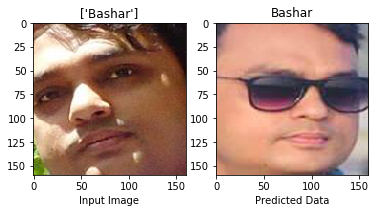

In [69]:
trainy_list = list(trainy)
p=int(predict_test)
if p in trainy_list:
    val = trainy_list.index(p)
#display Input Image
plt.subplot(1,2,1)
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)
plt.xlabel("Input Image")
#display Predicated data
plt.subplot(1,2,2)
plt.imshow(train_x[val])
trainy = out_encode.inverse_transform(trainy)
plt.title(trainy[val])
plt.xlabel("Predicted Data")

Reference:

[1] https://medium.com/clique-org/how-to-create-a-face-recognition-model-using-facenet-keras-fd65c0b092f1

[2] https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/